# 作業 : (Kaggle)鐵達尼生存預測
***
https://www.kaggle.com/c/titanic
***
1. https://hk.saowen.com/a/250747660cc38204b930a73421e159a2269f54e1e759a67d534735ba26df1dd8
2. https://www.kaggle.com/dansbecker/permutation-importance?utm_medium=email&utm_source=mailchimp&utm_campaign=ml4insights

In [1]:
# 做完特徵工程前的所有準備 (與前範例相同)
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier

data_path = 'data/'
df = pd.read_csv(data_path + 'titanic_train.csv')

train_Y = df['Survived']
df = df.drop(['PassengerId', 'Survived'] , axis=1)
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
# 因為需要把類別型與數值型特徵都加入, 故使用最簡版的特徵工程
LEncoder = LabelEncoder()
MMEncoder = MinMaxScaler()
for c in df.columns:
    df[c] = df[c].fillna(-1)
    if df[c].dtype == 'object':
        df[c] = LEncoder.fit_transform(list(df[c].values))
    df[c] = MMEncoder.fit_transform(df[c].values.reshape(-1, 1))
df.head()

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1.0,0.121348,1.0,0.283951,0.125,0.0,0.769118,0.014151,0.000000,1.000000
1,0.0,0.213483,0.0,0.481481,0.125,0.0,0.876471,0.139136,0.557823,0.333333
2,1.0,0.396629,0.0,0.333333,0.000,0.0,0.983824,0.015469,0.000000,1.000000
3,0.0,0.305618,0.0,0.444444,0.125,0.0,0.072059,0.103644,0.380952,1.000000
4,1.0,0.016854,1.0,0.444444,0.000,0.0,0.694118,0.015713,0.000000,1.000000


In [3]:
# 梯度提升樹擬合後, 將結果依照重要性由高到低排序 (note : D27作業中'Ticket'是第一名特徵, 'Age'是數值特徵中排名最高者)
estimator = GradientBoostingClassifier()
estimator.fit(df.values, train_Y)
feats = pd.Series(data=estimator.feature_importances_, index=df.columns)
feats = feats.sort_values(ascending=False)
feats

Sex         0.443984
Pclass      0.111886
Ticket      0.096975
Fare        0.088106
Name        0.083347
Age         0.072939
Cabin       0.071276
Embarked    0.012220
Parch       0.011550
SibSp       0.007718
dtype: float64

## 先用梯度提升機對鐵達尼生存預測做訓練，再用其特徵重要性回答下列問題

# 作業1
* 將特徵重要性較低的一半特徵刪除後，再做生存率預估，正確率是否有變化?

In [4]:
# 原始特徵 + 梯度提升樹
train_X = MMEncoder.fit_transform(df)
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8215972695810002

In [7]:
# 高重要性特徵 + 梯度提升樹 
high_feature = list(feats[:int(len(feats)/2)].index)
train_X = MMEncoder.fit_transform(df[high_feature])
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8125895324717789

# 作業2
* 將特徵重要性最高的兩個特徵做特徵組合，是否能再進一步提升預測力?

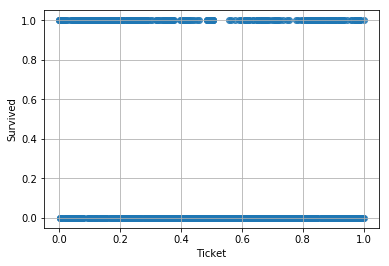

In [9]:
# 觀察重要特徵與目標的分布
# 第一名 : Ticket              
import seaborn as sns
import matplotlib.pyplot as plt
sns.regplot(x=df['Ticket'], y=train_Y, fit_reg=False)
plt.grid(True)

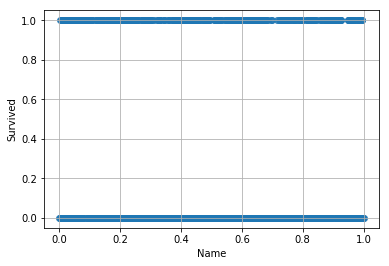

In [10]:
# 第二名 : Name        
sns.regplot(x=df['Name'], y=train_Y, fit_reg=False)
plt.grid(True)

In [11]:
# 製作四特徵 : 加, 乘, 互除(分母加1避免除0) 看效果 (Note: 數值原本已經最大最小化介於 [0,1] 區間, 這四種新特徵也會落在 [0,1] 區間)
df['Add_TN'] = df['Ticket'] + df['Name']
df['Multi_TN'] = df['Ticket'] * df['Name']
df['TN_div1p'] = df['Ticket'] / (df['Name']+1)
df['NT_div1p'] = df['Name'] / (df['Ticket']+1)

train_X = MMEncoder.fit_transform(df)
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8159476229942191

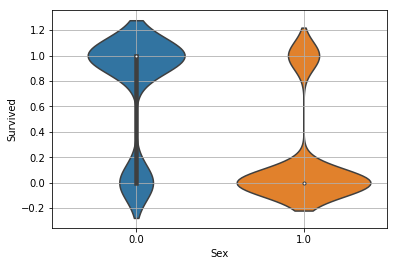

In [13]:
# Sex ~ Pclass
# 第一名 : Sex              
import seaborn as sns
import matplotlib.pyplot as plt
sns.violinplot(x=df['Sex'], y=train_Y)
plt.grid(True)

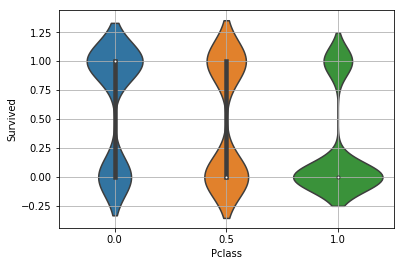

In [14]:
# 第二名 : Pclass              
import seaborn as sns
import matplotlib.pyplot as plt
sns.violinplot(x=df['Pclass'], y=train_Y)
plt.grid(True)

In [15]:
# 製作四特徵 : 加, 乘, 互除(分母加1避免除0) 看效果 (Note: 數值原本已經最大最小化介於 [0,1] 區間, 這四種新特徵也會落在 [0,1] 區間)
df['Add_SP'] = df['Sex'] + df['Pclass']
df['Multi_SP'] = df['Sex'] * df['Pclass']
df['SP_div1p'] = df['Sex'] / (df['Pclass']+1)
df['PS_div1p'] = df['Pclass'] / (df['Sex']+1)

train_X = MMEncoder.fit_transform(df)
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.829399454639659